In [1]:
!pip install python-mnist

  Using cached python_mnist-0.7-py2.py3-none-any.whl (9.6 kB)

[notice] A new release of pip available: 22.1.2 -> 22.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
from mnist import MNIST
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import numpy as np
import warnings
import tensorflow as tf
warnings.filterwarnings('ignore')
%matplotlib inline

In [3]:
%ls 

 Volume in drive C is System
 Volume Serial Number is E44B-3C76

 Directory of C:\WorkSpace\Amit\edvancer

07/27/2022  06:58 PM    <DIR>          .
07/27/2022  06:58 PM    <DIR>          ..
07/27/2022  06:58 PM    <DIR>          .ipynb_checkpoints
07/27/2022  06:58 PM            27,709 1.2 CNN with Tensorflow.ipynb
07/27/2022  06:52 PM         5,421,523 Convolution Neural Network.pdf
07/27/2022  06:54 PM    <DIR>          mnist_data
               2 File(s)      5,449,232 bytes
               4 Dir(s)  775,117,860,864 bytes free


In [4]:
mndata = MNIST(r'mnist_data')
images_train, labels_train = mndata.load_training()
images_test,labels_test=mndata.load_testing()

In [5]:
labels_train=np.array(labels_train).reshape(-1,1)
labels_test=np.array(labels_test).reshape(-1,1)

In [6]:
onehot=OneHotEncoder()
onehot.fit(labels_train)
labels_train=onehot.transform(labels_train)
labels_test=onehot.transform(labels_test)
labels_train=labels_train.toarray()
labels_test=labels_test.toarray()
images_train=np.array(images_train).reshape(60000,784)
images_test=np.array(images_test).reshape(10000,784)
images_train=images_train/255
images_test=images_test/255

In [8]:
# x_ph = tf.placeholder(tf.float32, shape=[None, 784]) 
x_ph = tf.compat.v1.placeholder(tf.float32, shape=[None, 784]) 
# y_ph = tf.placeholder(tf.float32, shape=[None, 10])
y_ph = tf.compat.v1.placeholder(tf.float32, shape=[None, 10])

RuntimeError: tf.placeholder() is not compatible with eager execution.

In [8]:
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

In [9]:
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')

In [10]:
# originally an image is simply a flat array of 784 numbers representing pixels
# we are reshaping it to original dimension of 28x28X1 , had this been a colored image. 
# there will be 3 channels instead of just 1 on the third dimension
x_image = tf.reshape(x_ph, [-1, 28, 28, 1])

In [11]:
W_conv1 = weight_variable([5, 5, 1, 32])
b_conv1 = bias_variable([32])

Instructions for updating:
Colocations handled automatically by placer.


In [12]:
h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)

In [13]:
W_conv2 = weight_variable([5, 5, 32, 64])
b_conv2 = bias_variable([64])

h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)

In [14]:
h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])

W_fc1 = weight_variable([7 * 7 * 64, 1024])
b_fc1 = bias_variable([1024])

h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

In [15]:
keep_prob = tf.placeholder(tf.float32)

h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [16]:
W_fc2 = weight_variable([1024, 200])
b_fc2 = bias_variable([200])

h_fc2= tf.nn.relu(tf.matmul(h_fc1_drop, W_fc2) + b_fc2)
h_fc2_drop=tf.nn.dropout(h_fc2,keep_prob)


In [17]:
W_fc3 = weight_variable([200, 10])
b_fc3 = bias_variable([10])

y_conv_logits=tf.matmul(h_fc2_drop, W_fc3) + b_fc3

In [18]:
loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits_v2(labels=y_ph, 
                                            logits=y_conv_logits))

train_step = tf.train.AdamOptimizer().minimize(loss)

correct_prediction = tf.equal(tf.argmax(y_conv_logits, 1),
                              tf.argmax(y_ph, 1))

accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
test_labels_predicted=tf.argmax(y_conv_logits, 1)

In [19]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    for i in range(1000):
        rand_int=np.random.choice(range(60000),50)
        x_train_batch=images_train[rand_int]
        y_train_batch=labels_train[rand_int]
        
        if i % 100 == 0:
            train_accuracy = accuracy.eval(feed_dict={x_ph: x_train_batch, y_ph: y_train_batch, keep_prob: 1.0})
            test_accuracy=accuracy.eval(feed_dict={x_ph: images_test, y_ph: labels_test, keep_prob: 1.0})
            print('step %d, training accuracy %g & testing accuracy %g' % (i, train_accuracy,test_accuracy))
            
        train_step.run(feed_dict={x_ph: x_train_batch, y_ph: y_train_batch, keep_prob: 0.5})

    print('test accuracy %g' % accuracy.eval(feed_dict={
      x_ph: images_test, y_ph: labels_test, keep_prob: 1.0}))
    test_labels_predicted=sess.run(test_labels_predicted,feed_dict={x_ph:images_test,keep_prob:1.0})

step 0, training accuracy 0.06 & testing accuracy 0.101
step 100, training accuracy 0.9 & testing accuracy 0.9252
step 200, training accuracy 0.96 & testing accuracy 0.9543
step 300, training accuracy 0.98 & testing accuracy 0.9642
step 400, training accuracy 0.92 & testing accuracy 0.9695
step 500, training accuracy 0.96 & testing accuracy 0.9763
step 600, training accuracy 1 & testing accuracy 0.9755
step 700, training accuracy 0.98 & testing accuracy 0.9807
step 800, training accuracy 0.94 & testing accuracy 0.9773
step 900, training accuracy 0.98 & testing accuracy 0.9821
test accuracy 0.9791


In [20]:
pd.crosstab(np.argmax(labels_test,axis=1),test_labels_predicted)

col_0,0,1,2,3,4,5,6,7,8,9
row_0,,,,,,,,,,
0,974,1,0,0,0,0,4,1,0,0
1,0,1134,1,0,0,0,0,0,0,0
2,5,18,984,1,2,0,1,18,3,0
3,0,0,4,979,0,11,0,12,3,1
4,0,2,0,0,976,0,0,1,1,2
5,2,1,0,1,0,873,3,2,9,1
6,2,5,0,0,4,1,939,0,7,0
7,0,5,3,1,0,0,0,1017,1,1
8,6,3,1,1,3,0,1,4,952,3


In [21]:
t=np.argmax(labels_test,axis=1)!=test_labels_predicted

In [22]:
[i for i,x in enumerate(t) if x]

[18,
 92,
 266,
 320,
 321,
 326,
 359,
 381,
 449,
 492,
 495,
 511,
 582,
 583,
 593,
 646,
 659,
 684,
 717,
 740,
 797,
 882,
 883,
 924,
 938,
 947,
 965,
 1014,
 1032,
 1033,
 1062,
 1138,
 1181,
 1182,
 1204,
 1226,
 1232,
 1247,
 1260,
 1299,
 1326,
 1337,
 1402,
 1425,
 1429,
 1500,
 1530,
 1621,
 1678,
 1681,
 1709,
 1717,
 1722,
 1790,
 1878,
 1901,
 1965,
 2043,
 2044,
 2098,
 2109,
 2129,
 2135,
 2186,
 2189,
 2237,
 2293,
 2298,
 2299,
 2387,
 2406,
 2414,
 2422,
 2433,
 2447,
 2454,
 2462,
 2488,
 2534,
 2582,
 2597,
 2598,
 2654,
 2720,
 2743,
 2760,
 2863,
 2896,
 2921,
 2927,
 2945,
 2953,
 2979,
 2995,
 3005,
 3030,
 3060,
 3073,
 3207,
 3250,
 3336,
 3369,
 3474,
 3475,
 3503,
 3511,
 3520,
 3558,
 3597,
 3599,
 3688,
 3785,
 3796,
 3808,
 3850,
 3853,
 3869,
 3985,
 4007,
 4044,
 4075,
 4152,
 4163,
 4176,
 4205,
 4224,
 4248,
 4256,
 4284,
 4289,
 4306,
 4356,
 4369,
 4384,
 4435,
 4472,
 4497,
 4500,
 4536,
 4571,
 4601,
 4615,
 4699,
 4731,
 4740,
 4761,
 4807,


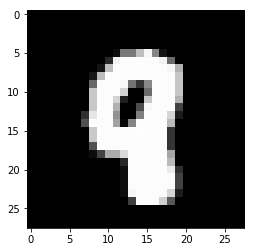

predicted label: 9
real label: 8


In [27]:
ind=947
sample_image = images_test[ind] 
sample_image = np.array(sample_image, dtype='float')
pixels = sample_image.reshape((28, 28))
plt.imshow(pixels, cmap='gray')
plt.show()
print('predicted label:',test_labels_predicted[ind])
print('real label:',np.argmax(labels_test[ind]))

In [24]:
sample_image.shape

(784,)